### Big Data Analytics mini project on Exam Results Analysis 
### Dataset:Exam_Results_X_2010-Board.csv
### Source:https://www.data.gov.in/resource/results-high-school-examination-2010-annual-and-supplementary-examination-results 

# 📊 Exam Results Analytics Parameters
## 1. Pass Percentage by Board

This parameter calculates the overall pass rate for each education board (Central, State, or Special Boards).

A high pass percentage reflects effective teaching standards and student preparedness.

A low pass percentage signals possible challenges such as lack of resources, exam difficulty, or socio-economic factors.

## 2. Gender-wise Performance

Compares pass percentages between boys and girls across all boards.

Highlights performance gaps between genders.

Useful for identifying whether initiatives promoting girls’ education are yielding results.

## 3. Category-wise Performance (SC/ST/All Categories)

Evaluates performance differences among SC, ST, and all-category students.

SC/ST students generally show lower pass % and fewer students with ≥60% marks.

This parameter helps policymakers design targeted educational support programs.

## 4. Marks Distribution

Divides students into performance groups:

≥60% (High Performers)

50–60% (Average Performers)

Below 50% (Low Performers)
This distribution provides insights into quality of performance, not just pass/fail outcomes.

## 5. Top & Bottom Performing Boards

Identifies boards with the highest and lowest pass percentages.

Top boards reflect best practices in education.

Bottom boards highlight areas needing policy intervention and quality improvements.

## 6. Regular vs Private Students

Analyzes performance differences between regular students and private candidates.

Regular students often perform better due to structured schooling.

Private candidates may face challenges in preparation and resource availability.

## 7. Board Type Comparison (Central vs State Boards)

Measures how national boards (CBSE, ICSE) perform against state boards.

National boards often show higher pass percentages.

State boards reflect regional disparities in infrastructure and teaching quality.

## 8. Gender Gap in High Performance

Looks specifically at the ≥60% marks group to check whether boys or girls dominate among top scorers.

This indicates who is excelling at the highest academic level, not just passing.

In [34]:
# ---------------------------
# 1. Setup & Import Libraries
# ---------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
# Spark Session
spark = SparkSession.builder.appName("Exam Results Analysis").getOrCreate()



In [53]:
# ---------------------------
# 2. Load Data
# ---------------------------
file_path = "Exam_Results_X_2010-Board.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.printSchema()
df.show(2)

root
 |-- Board Type: string (nullable = true)
 |-- Name of the Board: string (nullable = true)
 |-- Regular Students - All Categories - Number of Students - Appeared - Boys: integer (nullable = true)
 |-- Regular Students - All Categories - Number of Students - Appeared - Girls: integer (nullable = true)
 |-- Regular Students - All Categories - Number of Students - Appeared - Total: string (nullable = true)
 |-- Regular Students - All Categories - Number of Students - Passed - Annual - Boys: integer (nullable = true)
 |-- Regular Students - All Categories - Number of Students - Passed - Annual - Girls: integer (nullable = true)
 |-- Regular Students - All Categories - Number of Students - Passed - Annual - Total: string (nullable = true)
 |-- Regular Students - All Categories - Number of Students - Passed - Supplementary - Boys: string (nullable = true)
 |-- Regular Students - All Categories - Number of Students - Passed - Supplementary - Girls: string (nullable = true)
 |-- Regular S

In [38]:
# ---------------------------
# 3. Select Key Columns
# ---------------------------
df_selected = df.select(
    "Board Type",
    "Name of the Board",
    col("Regular + Private Students - All Categories - Pass %age - Boys").alias("Pass_Boys"),
    col("Regular + Private Students - All Categories - Pass %age - Girls").alias("Pass_Girls"),
    col("Regular + Private Students - All Categories - Pass %age - Total").alias("Pass_Total"),
    col("All Categories - Percentage of Students passed with marks - 60% and above").alias("Above_60"),
    col("All Categories - Percentage of Students passed with marks - 50% to below 60%").alias("Between_50_60"),
    col("All Categories - Percentage of Students passed with marks - Below 50%").alias("Below_50"),
    col("SC Students - Percentage of Students passed with marks - 60% and above").alias("SC_Above_60"),
    col("ST Students - Percentage of Students passed with marks - 60% and above").alias("ST_Above_60")
)

In [52]:
# ---------------------------
# 4. Data Analytics in PySpark
# ---------------------------

# Overall Average Pass %
overall_pass = df_selected.agg(avg("Pass_Total").alias("Avg_Pass_Percentage"))
print("\n✅ Overall Average Pass %:")
overall_pass.show()

# Gender-wise average
gender_avg = df_selected.agg(
    avg("Pass_Boys").alias("Avg_Boys"),
    avg("Pass_Girls").alias("Avg_Girls")
)
print("\n✅ Gender-wise Average Pass %:")
gender_avg.show()

# Top & Bottom Boards
best_boards = df_selected.orderBy(col("Pass_Total").desc()).limit(5)
worst_boards = df_selected.orderBy(col("Pass_Total").asc()).limit(5)

print("\n✅ Top 5 Boards:")
best_boards.show(truncate=False)

print("\n✅ Bottom 5 Boards:")
worst_boards.show(truncate=False)


✅ Overall Average Pass %:
+-------------------+
|Avg_Pass_Percentage|
+-------------------+
|  73.93714285714285|
+-------------------+


✅ Gender-wise Average Pass %:
+-----------------+-----------------+
|         Avg_Boys|        Avg_Girls|
+-----------------+-----------------+
|73.92571428571428|74.27428571428571|
+-----------------+-----------------+


✅ Top 5 Boards:
+--------------+-----------------------------------------------------------------+---------+----------+----------+--------+-------------+--------+-----------+-----------+
|Board Type    |Name of the Board                                                |Pass_Boys|Pass_Girls|Pass_Total|Above_60|Between_50_60|Below_50|SC_Above_60|ST_Above_60|
+--------------+-----------------------------------------------------------------+---------+----------+----------+--------+-------------+--------+-----------+-----------+
|State Boards  |Chhatisgarh Sanskriti Vidya Mandalam                             |99.5     |100.0     |99.7   

In [50]:
from pyspark.sql.functions import col, when

# Replace "NA" with NULL in the numeric columns
df_selected = df_selected.withColumn("SC_Above_60", when(col("SC_Above_60")=="NA", None).otherwise(col("SC_Above_60")))
df_selected = df_selected.withColumn("ST_Above_60", when(col("ST_Above_60")=="NA", None).otherwise(col("ST_Above_60")))
df_selected = df_selected.withColumn("Above_60", when(col("Above_60")=="NA", None).otherwise(col("Above_60")))

# Cast them to double after cleaning
df_selected = df_selected.withColumn("SC_Above_60", col("SC_Above_60").cast("double"))
df_selected = df_selected.withColumn("ST_Above_60", col("ST_Above_60").cast("double"))
df_selected = df_selected.withColumn("Above_60", col("Above_60").cast("double"))

# Now your aggregation will work
sc_st_avg = df_selected.agg(
    avg("SC_Above_60").alias("Avg_SC_Above_60"),
    avg("ST_Above_60").alias("Avg_ST_Above_60"),
    avg("Above_60").alias("Avg_Overall_Above_60")
)

print("\n✅ SC/ST vs Overall (Above 60% pass %):")
sc_st_avg.show()



✅ SC/ST vs Overall (Above 60% pass %):
+---------------+---------------+--------------------+
|Avg_SC_Above_60|Avg_ST_Above_60|Avg_Overall_Above_60|
+---------------+---------------+--------------------+
|         29.564|           23.6|   32.86071428571429|
+---------------+---------------+--------------------+



In [43]:

# 5. Convert to Pandas for Visuals
# ---------------------------
df_pd = df_selected.toPandas()

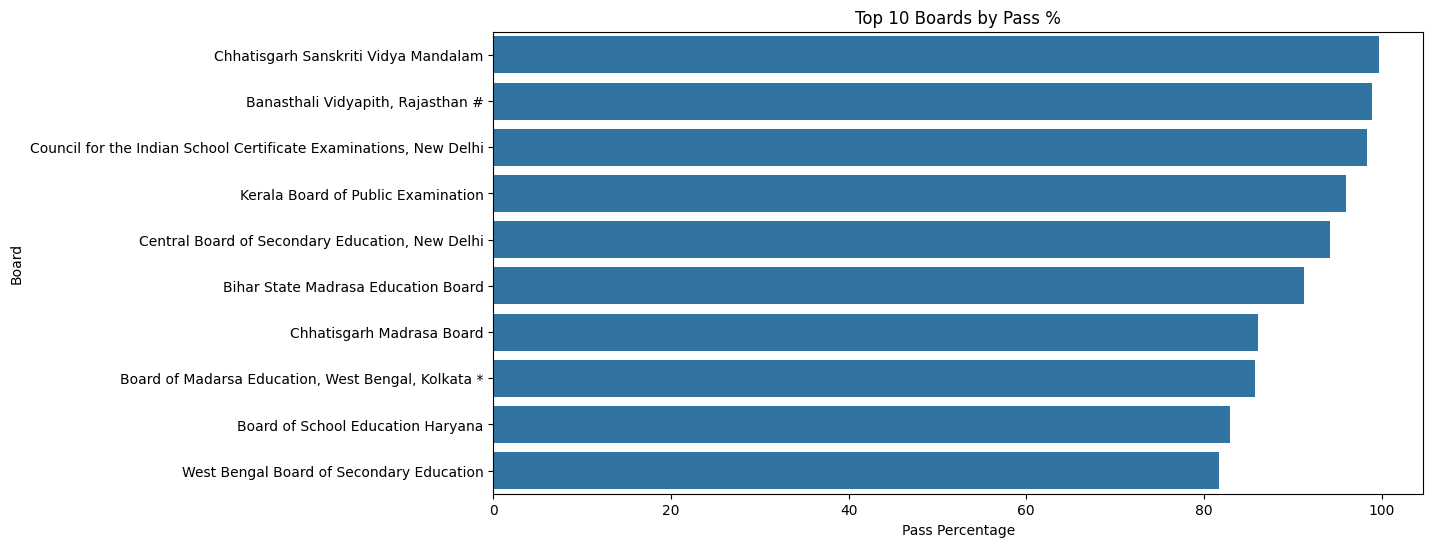

In [44]:
# ---------------------------
# 6. Visualization
# ---------------------------

# 1. Bar Chart - Top 10 Boards by Pass %
plt.figure(figsize=(12,6))
sns.barplot(x="Pass_Total", y="Name of the Board",
            data=df_pd.sort_values("Pass_Total", ascending=False).head(10))
plt.title("Top 10 Boards by Pass %")
plt.xlabel("Pass Percentage")
plt.ylabel("Board")
plt.show()


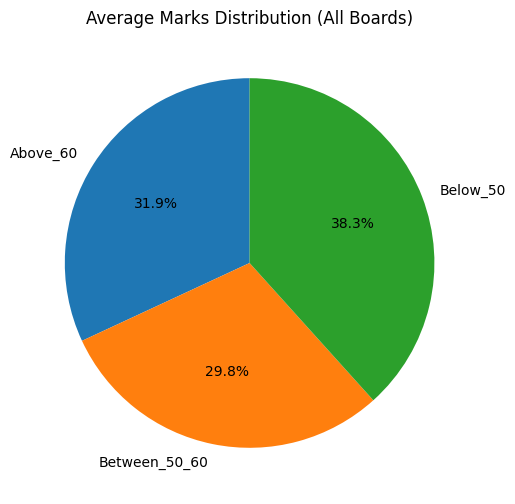

In [46]:
# Convert columns to numeric (if they are strings of numbers)
df_pd[["Above_60","Between_50_60","Below_50"]] = df_pd[["Above_60","Between_50_60","Below_50"]].apply(pd.to_numeric, errors="coerce")

# Now calculate mean
marks_avg = df_pd[["Above_60","Between_50_60","Below_50"]].mean()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(marks_avg, labels=marks_avg.index, autopct="%1.1f%%", startangle=90)
plt.title("Average Marks Distribution (All Boards)")
plt.show()


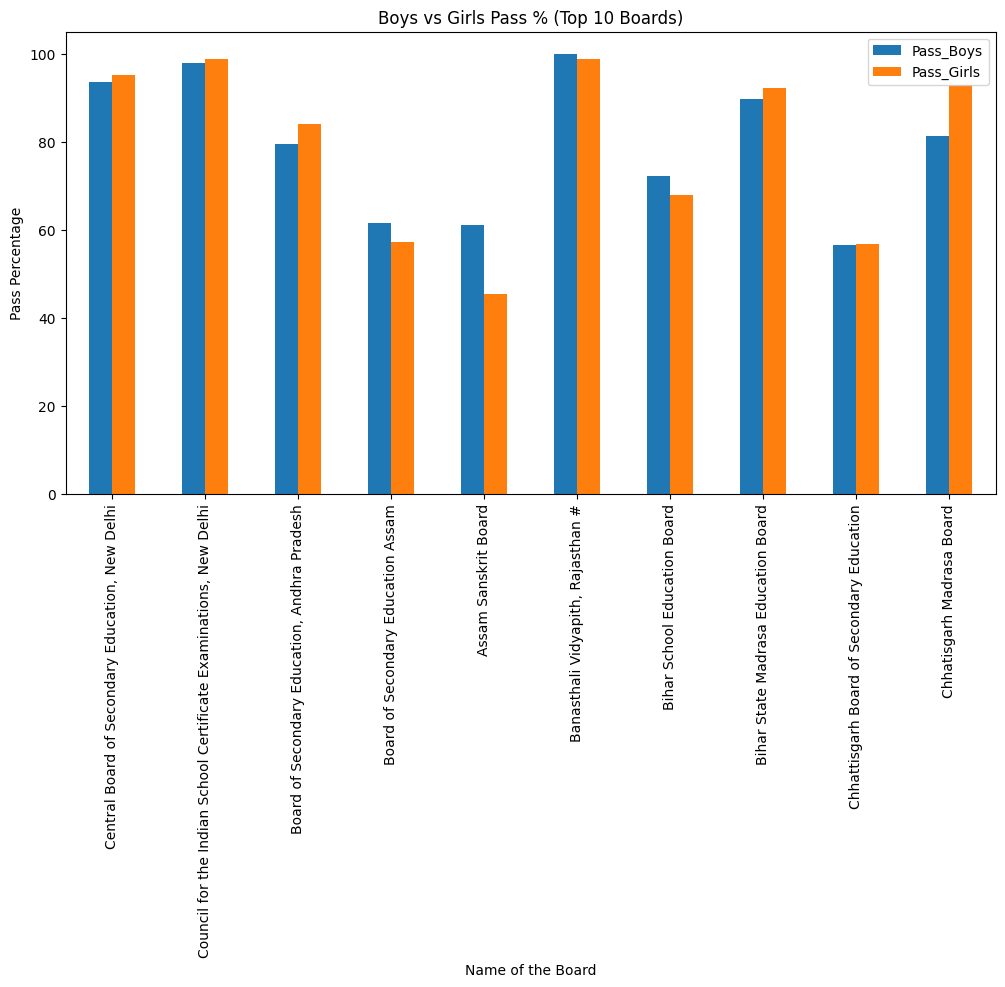

In [47]:
# 3. Stacked Bar - Boys vs Girls Pass % (Top 10)
df_gender = df_pd[["Name of the Board","Pass_Boys","Pass_Girls"]].dropna().head(10)
df_gender.set_index("Name of the Board").plot(kind="bar", stacked=False, figsize=(12,6))
plt.title("Boys vs Girls Pass % (Top 10 Boards)")
plt.ylabel("Pass Percentage")
plt.show()


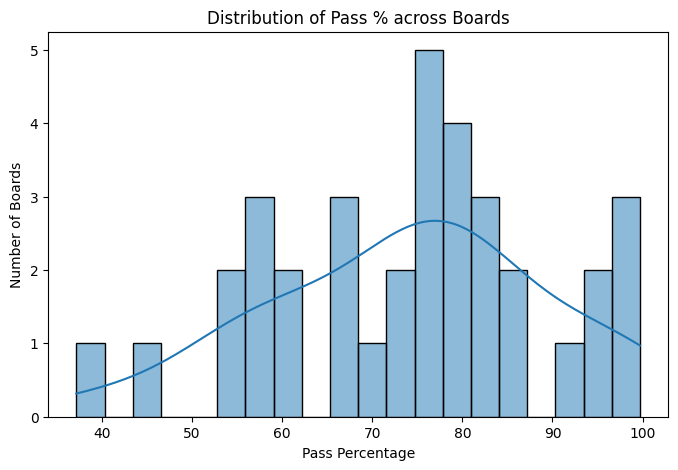

In [48]:
# 4. Histogram - Distribution of Pass %
plt.figure(figsize=(8,5))
sns.histplot(df_pd["Pass_Total"].dropna(), bins=20, kde=True)
plt.title("Distribution of Pass % across Boards")
plt.xlabel("Pass Percentage")
plt.ylabel("Number of Boards")
plt.show()